# Airbnb data analysis and smart pricing tool

Final project for Data Science bootcamp organized by Sages (Kodołamacz).

### Table of contents
1. Abstract
2. Dataset
3. Prerequisites
4. Data exploration
5. Data preparing for modeling
6. Modeling
...

Data exploration and visualization
Data preparation for modeling
Modeling data

### 1. Abstract

### 2. Dataset

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import statsmodels
import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

import keplergl

In [184]:
df = pd.read_csv('./dataset/AB_NYC_2019.csv')


In [185]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [187]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In this step we have to choose column which will be analyzed in next steps. 
- Column "id" is unique value for each observation so we will not use it in further analysis. 
- Column "name" contains title of each listings and won't be analyzed in this part of the project. (It could be used to find if some specific words used in title are related to price.)
- Columns "host_id" and "host_name" refers to specific users and it shouldn't be analyzed.
- Column "last_review" contain informations about date of last review so it shouldnt be related to price.

In next step abovementioned columns will be dropped.

# Tu można przeanalizować po kolei kolumny pod kątem przeydatności do modelu !!!

In [188]:
df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True) 
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Now let's see if analyzed dataset contains null values.

In [189]:
df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We can notice that null values appears only in column "reviews_per_month". This column receive null value only if listing don't have any reviews, so we can replace null values to zeros.

Unfortunately we don't have any specific information about reviews, only total number. Therefore, we cannot assess whether the reviews are positive or negative. Detailed scoring data would definitelly increase model performance.

In [190]:
df.fillna({'reviews_per_month':0}, inplace = True)

In [191]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

There is only 16 observations with null values so we can delete them because it is marginal number of observation and won't affect the result - column "name"

In [192]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


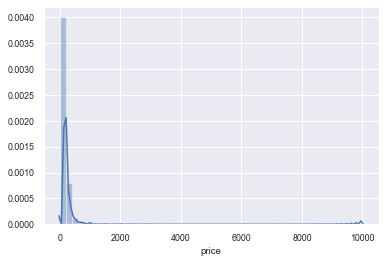

In [161]:
sns.distplot(df['price'])

We can notice that price distribution is far from Gaussian distribution. 
There are some outliers in the analyzed set. So we can try to use logarythmic transformation to change the distribution and in next step get rid off outliers.

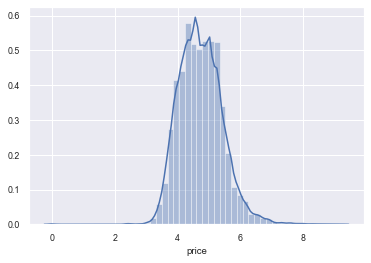

In [162]:
sns.distplot(np.log1p(df['price']))

After this transformation price has distribution similiar to Gaussian. We will also remove outliers by choosing only values between 2.5 and 8 due to analysis of chart above. 

In [163]:
df = df[np.log1p(df['price'])<8]
df = df[np.log1p(df['price'])>2.5]
df.price.describe()

count    48807.000000
mean       146.972975
std        151.039474
min         12.000000
25%         69.000000
50%        105.000000
75%        175.000000
max       2900.000000
Name: price, dtype: float64

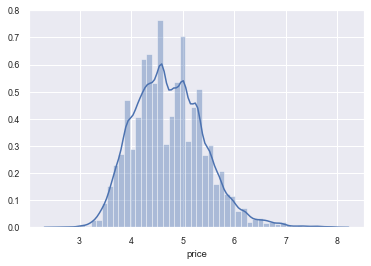

In [164]:
df['price'] = np.log1p(df['price'])
sns.distplot(df['price'])

In [ ]:
Now we have to replace categorical features with numerical that model can handle input data. get_dummies or maybe label encoder ?

In [ ]:
df = pd.get_dummies(df)
df.head()

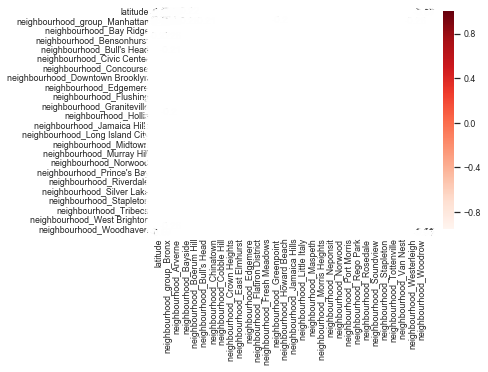

In [183]:
sns.heatmap(df.corr(), annot=True, linewidths=0.1, cmap='Reds')


In [166]:
X = df.drop(['price'], axis=1)
y = df.price

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9)

In [171]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [178]:
model = RidgeCV()

In [179]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [180]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)

In [181]:
print('MAE (Mean Absolute Error): %s' %mae)
print('MSE (Mean Squared Error): %s' %mse)
print('RMSE (Root mean squared error): %s' %rmse)
print('R2 score: %s' %r2)

MAE (Mean Absolute Error): 0.3442170566145518
MSE (Mean Squared Error): 0.21754780039352548
RMSE (Root mean squared error): 0.46642019724013395
R2 score: 0.5257154964210087


Text(0, 0.5, 'Test')

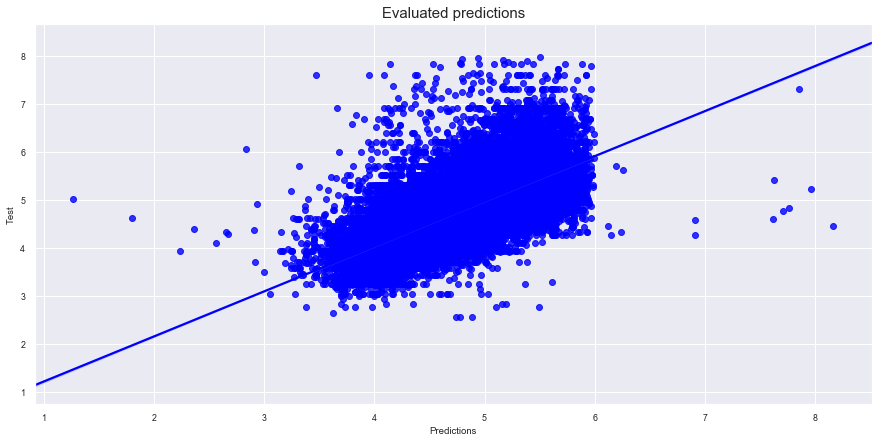

In [182]:
plt.figure(figsize=(15,7))
sns.regplot(y=y_test, x=y_pred, color='blue')
plt.title('Evaluated predictions', fontsize=15)
plt.xlabel('Predictions')
plt.ylabel('Test')

In [46]:
y_pred

array([-8.71572665e+14, -2.21830167e+15, -3.13604833e+15, ...,
       -3.81896382e+15, -4.09236569e+15, -3.69029516e+15])

In [14]:
# making class to select numerical or categorical columns
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]

In [15]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [71]:
pipeline_test = Pipeline([("select_cat", DataFrameSelector(['room_type']))])
pipeline_test.fit_transform(X_train)

,room_type
2391,Entire home/apt
2742,Private room
34530,Entire home/apt
9999,Private room
29481,Private room
...,...
33939,Entire home/apt
47552,Private room
7252,Entire home/apt
27028,Entire home/apt


Przygotowanie danych do modelowania 
Onehotencoder dla neighbourhood i neighbourhood_group, room_type

Dla kolumny name spróbujmy 
CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

In [6]:
from keplergl import KeplerGl
map_1 = KeplerGl()



User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [7]:
map_1.add_data(data=df, name='price')
map_1

KeplerGl(data={'price': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2…